In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 32,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s]


In [8]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7703 | F1: 0.3589
[Validate] Cardiomegaly AUC: 0.8710 | F1: 0.2971
[Validate] Consolidation AUC: 0.7638 | F1: 0.1889
[Validate] Edema AUC: 0.9083 | F1: 0.2969
[Validate] Effusion AUC: 0.8737 | F1: 0.5468
[Validate] Emphysema AUC: 0.9187 | F1: 0.4199
[Validate] Fibrosis AUC: 0.7778 | F1: 0.1679
[Validate] Hernia AUC: 0.9119 | F1: 0.2581
[Validate] Infiltration AUC: 0.6889 | F1: 0.3949
[Validate] Mass AUC: 0.7948 | F1: 0.3434
[Validate] Nodule AUC: 0.7354 | F1: 0.2652
[Validate] Pleural_Thickening AUC: 0.7473 | F1: 0.1455
[Validate] Pneumonia AUC: 0.7661 | F1: 0.1084
[Validate] Pneumothorax AUC: 0.8458 | F1: 0.4194
[Validate] Avg AUC: 0.8124, Avg F1: 0.3008
Training Loss: 0.0467
Validation Loss: 0.0441
Validation AUC: 0.8124
Validation F1: 0.3008
✓ NEW BEST MODEL! Saved at models/best_model_20250915-215308.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7902 | F1: 0.3805
[Validate] Cardiomegaly AUC: 0.8904 | F1: 0.3348
[Validate] Consolidation AUC: 0.7954 | F1: 0.2239
[Validate] Edema AUC: 0.9143 | F1: 0.3123
[Validate] Effusion AUC: 0.8853 | F1: 0.5663
[Validate] Emphysema AUC: 0.9274 | F1: 0.4582
[Validate] Fibrosis AUC: 0.7641 | F1: 0.1453
[Validate] Hernia AUC: 0.9684 | F1: 0.4242
[Validate] Infiltration AUC: 0.7079 | F1: 0.4048
[Validate] Mass AUC: 0.8178 | F1: 0.4095
[Validate] Nodule AUC: 0.7357 | F1: 0.3152
[Validate] Pleural_Thickening AUC: 0.7284 | F1: 0.1735
[Validate] Pneumonia AUC: 0.7787 | F1: 0.0994
[Validate] Pneumothorax AUC: 0.8660 | F1: 0.4275
[Validate] Avg AUC: 0.8264, Avg F1: 0.3340
Training Loss: 0.0440
Validation Loss: 0.0426
Validation AUC: 0.8264
Validation F1: 0.3340
✓ NEW BEST MODEL! Saved at models/best_model_20250915-221844.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7932 | F1: 0.3962
[Validate] Cardiomegaly AUC: 0.8931 | F1: 0.3615
[Validate] Consolidation AUC: 0.7847 | F1: 0.2392
[Validate] Edema AUC: 0.8977 | F1: 0.3181
[Validate] Effusion AUC: 0.8844 | F1: 0.5624
[Validate] Emphysema AUC: 0.9231 | F1: 0.4251
[Validate] Fibrosis AUC: 0.8073 | F1: 0.1909
[Validate] Hernia AUC: 0.9685 | F1: 0.4103
[Validate] Infiltration AUC: 0.7086 | F1: 0.4137
[Validate] Mass AUC: 0.8297 | F1: 0.4043
[Validate] Nodule AUC: 0.7577 | F1: 0.3198
[Validate] Pleural_Thickening AUC: 0.7482 | F1: 0.1798
[Validate] Pneumonia AUC: 0.7816 | F1: 0.0890
[Validate] Pneumothorax AUC: 0.8481 | F1: 0.4038
[Validate] Avg AUC: 0.8304, Avg F1: 0.3367
Training Loss: 0.0432
Validation Loss: 0.0429
Validation AUC: 0.8304
Validation F1: 0.3367
✓ NEW BEST MODEL! Saved at models/best_model_20250915-224420.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7929 | F1: 0.3769
[Validate] Cardiomegaly AUC: 0.9019 | F1: 0.3630
[Validate] Consolidation AUC: 0.7872 | F1: 0.2259
[Validate] Edema AUC: 0.9175 | F1: 0.3290
[Validate] Effusion AUC: 0.8919 | F1: 0.5801
[Validate] Emphysema AUC: 0.9234 | F1: 0.4548
[Validate] Fibrosis AUC: 0.7955 | F1: 0.2083
[Validate] Hernia AUC: 0.9643 | F1: 0.5128
[Validate] Infiltration AUC: 0.7050 | F1: 0.4028
[Validate] Mass AUC: 0.8079 | F1: 0.3796
[Validate] Nodule AUC: 0.7595 | F1: 0.3217
[Validate] Pleural_Thickening AUC: 0.7410 | F1: 0.2043
[Validate] Pneumonia AUC: 0.8022 | F1: 0.1111
[Validate] Pneumothorax AUC: 0.8646 | F1: 0.4593
[Validate] Avg AUC: 0.8325, Avg F1: 0.3521
Training Loss: 0.0426
Validation Loss: 0.0426
Validation AUC: 0.8325
Validation F1: 0.3521
✓ NEW BEST MODEL! Saved at models/best_model_20250915-231021.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8131 | F1: 0.3994
[Validate] Cardiomegaly AUC: 0.9087 | F1: 0.3965
[Validate] Consolidation AUC: 0.7953 | F1: 0.2424
[Validate] Edema AUC: 0.9197 | F1: 0.3578
[Validate] Effusion AUC: 0.8856 | F1: 0.5710
[Validate] Emphysema AUC: 0.9414 | F1: 0.4812
[Validate] Fibrosis AUC: 0.8004 | F1: 0.2174
[Validate] Hernia AUC: 0.9553 | F1: 0.5500
[Validate] Infiltration AUC: 0.7091 | F1: 0.4013
[Validate] Mass AUC: 0.8277 | F1: 0.4038
[Validate] Nodule AUC: 0.7733 | F1: 0.3326
[Validate] Pleural_Thickening AUC: 0.7503 | F1: 0.1988
[Validate] Pneumonia AUC: 0.7940 | F1: 0.1000
[Validate] Pneumothorax AUC: 0.8542 | F1: 0.4090
[Validate] Avg AUC: 0.8377, Avg F1: 0.3615
Training Loss: 0.0422
Validation Loss: 0.0421
Validation AUC: 0.8377
Validation F1: 0.3615
✓ NEW BEST MODEL! Saved at models/best_model_20250915-233545.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8067 | F1: 0.3906
[Validate] Cardiomegaly AUC: 0.9116 | F1: 0.3727
[Validate] Consolidation AUC: 0.7965 | F1: 0.2402
[Validate] Edema AUC: 0.9144 | F1: 0.3552
[Validate] Effusion AUC: 0.8902 | F1: 0.5790
[Validate] Emphysema AUC: 0.9425 | F1: 0.4633
[Validate] Fibrosis AUC: 0.8324 | F1: 0.2146
[Validate] Hernia AUC: 0.9634 | F1: 0.5714
[Validate] Infiltration AUC: 0.7165 | F1: 0.4132
[Validate] Mass AUC: 0.8265 | F1: 0.4036
[Validate] Nodule AUC: 0.7518 | F1: 0.3321
[Validate] Pleural_Thickening AUC: 0.7652 | F1: 0.1970
[Validate] Pneumonia AUC: 0.8114 | F1: 0.1082
[Validate] Pneumothorax AUC: 0.8705 | F1: 0.4971
[Validate] Avg AUC: 0.8428, Avg F1: 0.3670
Training Loss: 0.0419
Validation Loss: 0.0419
Validation AUC: 0.8428
Validation F1: 0.3670
✓ NEW BEST MODEL! Saved at models/best_model_20250916-000123.pth

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8065 | F1: 0.3950
[Validate] Cardiomegaly AUC: 0.9215 | F1: 0.4013
[Validate] Consolidation AUC: 0.7828 | F1: 0.2310
[Validate] Edema AUC: 0.9212 | F1: 0.3473
[Validate] Effusion AUC: 0.8899 | F1: 0.5718
[Validate] Emphysema AUC: 0.9345 | F1: 0.4775
[Validate] Fibrosis AUC: 0.7838 | F1: 0.1739
[Validate] Hernia AUC: 0.9705 | F1: 0.6341
[Validate] Infiltration AUC: 0.7051 | F1: 0.4027
[Validate] Mass AUC: 0.8421 | F1: 0.4199
[Validate] Nodule AUC: 0.7711 | F1: 0.3430
[Validate] Pleural_Thickening AUC: 0.7423 | F1: 0.2014
[Validate] Pneumonia AUC: 0.7934 | F1: 0.0884
[Validate] Pneumothorax AUC: 0.8623 | F1: 0.4541
[Validate] Avg AUC: 0.8376, Avg F1: 0.3673
Training Loss: 0.0416
Validation Loss: 0.0418
Validation AUC: 0.8376
Validation F1: 0.3673
No improvement. Patience: 1/5

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8122 | F1: 0.4065
[Validate] Cardiomegaly AUC: 0.9193 | F1: 0.3726
[Validate] Consolidation AUC: 0.7972 | F1: 0.2381
[Validate] Edema AUC: 0.9174 | F1: 0.3181
[Validate] Effusion AUC: 0.8879 | F1: 0.5710
[Validate] Emphysema AUC: 0.9430 | F1: 0.4778
[Validate] Fibrosis AUC: 0.7982 | F1: 0.2172
[Validate] Hernia AUC: 0.9441 | F1: 0.6452
[Validate] Infiltration AUC: 0.7092 | F1: 0.4118
[Validate] Mass AUC: 0.8485 | F1: 0.4090
[Validate] Nodule AUC: 0.7821 | F1: 0.3475
[Validate] Pleural_Thickening AUC: 0.7512 | F1: 0.1985
[Validate] Pneumonia AUC: 0.7870 | F1: 0.0939
[Validate] Pneumothorax AUC: 0.8593 | F1: 0.4554
[Validate] Avg AUC: 0.8398, Avg F1: 0.3688
Training Loss: 0.0414
Validation Loss: 0.0414
Validation AUC: 0.8398
Validation F1: 0.3688
No improvement. Patience: 2/5

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8092 | F1: 0.3883
[Validate] Cardiomegaly AUC: 0.9221 | F1: 0.4022
[Validate] Consolidation AUC: 0.7958 | F1: 0.2314
[Validate] Edema AUC: 0.9213 | F1: 0.3397
[Validate] Effusion AUC: 0.8948 | F1: 0.5837
[Validate] Emphysema AUC: 0.9376 | F1: 0.5026
[Validate] Fibrosis AUC: 0.8292 | F1: 0.2111
[Validate] Hernia AUC: 0.9587 | F1: 0.6875
[Validate] Infiltration AUC: 0.7091 | F1: 0.4056
[Validate] Mass AUC: 0.8434 | F1: 0.4241
[Validate] Nodule AUC: 0.7722 | F1: 0.3562
[Validate] Pleural_Thickening AUC: 0.7615 | F1: 0.1834
[Validate] Pneumonia AUC: 0.8115 | F1: 0.1241
[Validate] Pneumothorax AUC: 0.8708 | F1: 0.4545
[Validate] Avg AUC: 0.8455, Avg F1: 0.3782
Training Loss: 0.0411
Validation Loss: 0.0412
Validation AUC: 0.8455
Validation F1: 0.3782
✓ NEW BEST MODEL! Saved at models/best_model_20250916-011745.pth

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8134 | F1: 0.4034
[Validate] Cardiomegaly AUC: 0.9200 | F1: 0.3873
[Validate] Consolidation AUC: 0.7926 | F1: 0.2331
[Validate] Edema AUC: 0.9142 | F1: 0.3299
[Validate] Effusion AUC: 0.8916 | F1: 0.5816
[Validate] Emphysema AUC: 0.9446 | F1: 0.4819
[Validate] Fibrosis AUC: 0.8374 | F1: 0.2056
[Validate] Hernia AUC: 0.9613 | F1: 0.6857
[Validate] Infiltration AUC: 0.7136 | F1: 0.4076
[Validate] Mass AUC: 0.8433 | F1: 0.4265
[Validate] Nodule AUC: 0.7825 | F1: 0.3548
[Validate] Pleural_Thickening AUC: 0.7794 | F1: 0.2048
[Validate] Pneumonia AUC: 0.8158 | F1: 0.1109
[Validate] Pneumothorax AUC: 0.8742 | F1: 0.4715
[Validate] Avg AUC: 0.8489, Avg F1: 0.3775
Training Loss: 0.0408
Validation Loss: 0.0414
Validation AUC: 0.8489
Validation F1: 0.3775
✓ NEW BEST MODEL! Saved at models/best_model_20250916-014334.pth

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x791a12990040><function _MultiProcessingDataLoaderIter.__del__ at 0x791a12990040>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
 if w.is_alive():
           ^ ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8101 | F1: 0.4064
[Validate] Cardiomegaly AUC: 0.9277 | F1: 0.3792
[Validate] Consolidation AUC: 0.7892 | F1: 0.2340
[Validate] Edema AUC: 0.9078 | F1: 0.2963
[Validate] Effusion AUC: 0.8876 | F1: 0.5584
[Validate] Emphysema AUC: 0.9424 | F1: 0.4724
[Validate] Fibrosis AUC: 0.8072 | F1: 0.1681
[Validate] Hernia AUC: 0.9715 | F1: 0.7179
[Validate] Infiltration AUC: 0.7029 | F1: 0.4059
[Validate] Mass AUC: 0.8379 | F1: 0.4146
[Validate] Nodule AUC: 0.7827 | F1: 0.3609
[Validate] Pleural_Thickening AUC: 0.7791 | F1: 0.1943
[Validate] Pneumonia AUC: 0.7897 | F1: 0.0902
[Validate] Pneumothorax AUC: 0.8715 | F1: 0.4610
[Validate] Avg AUC: 0.8434, Avg F1: 0.3685
Training Loss: 0.0406
Validation Loss: 0.0421
Validation AUC: 0.8434
Validation F1: 0.3685
No improvement. Patience: 1/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8146 | F1: 0.4072
[Validate] Cardiomegaly AUC: 0.9288 | F1: 0.4094
[Validate] Consolidation AUC: 0.7949 | F1: 0.2296
[Validate] Edema AUC: 0.9146 | F1: 0.3470
[Validate] Effusion AUC: 0.8937 | F1: 0.5747
[Validate] Emphysema AUC: 0.9465 | F1: 0.5030
[Validate] Fibrosis AUC: 0.8330 | F1: 0.2118
[Validate] Hernia AUC: 0.9811 | F1: 0.7429
[Validate] Infiltration AUC: 0.7177 | F1: 0.4107
[Validate] Mass AUC: 0.8547 | F1: 0.4367
[Validate] Nodule AUC: 0.7838 | F1: 0.3827
[Validate] Pleural_Thickening AUC: 0.7836 | F1: 0.2046
[Validate] Pneumonia AUC: 0.8072 | F1: 0.0945
[Validate] Pneumothorax AUC: 0.8753 | F1: 0.4739
[Validate] Avg AUC: 0.8521, Avg F1: 0.3878
Training Loss: 0.0394
Validation Loss: 0.0408
Validation AUC: 0.8521
Validation F1: 0.3878
✓ NEW BEST MODEL! Saved at models/best_model_20250916-023400.pth

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8181 | F1: 0.4052
[Validate] Cardiomegaly AUC: 0.9306 | F1: 0.3899
[Validate] Consolidation AUC: 0.7984 | F1: 0.2331
[Validate] Edema AUC: 0.9168 | F1: 0.3424
[Validate] Effusion AUC: 0.8948 | F1: 0.5767
[Validate] Emphysema AUC: 0.9465 | F1: 0.4971
[Validate] Fibrosis AUC: 0.8264 | F1: 0.2265
[Validate] Hernia AUC: 0.9816 | F1: 0.7222
[Validate] Infiltration AUC: 0.7170 | F1: 0.4109
[Validate] Mass AUC: 0.8519 | F1: 0.4344
[Validate] Nodule AUC: 0.7825 | F1: 0.3728
[Validate] Pleural_Thickening AUC: 0.7850 | F1: 0.2063
[Validate] Pneumonia AUC: 0.8032 | F1: 0.0919
[Validate] Pneumothorax AUC: 0.8723 | F1: 0.4805
[Validate] Avg AUC: 0.8518, Avg F1: 0.3850
Training Loss: 0.0391
Validation Loss: 0.0406
Validation AUC: 0.8518
Validation F1: 0.3850
No improvement. Patience: 1/5

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8178 | F1: 0.4060
[Validate] Cardiomegaly AUC: 0.9280 | F1: 0.3836
[Validate] Consolidation AUC: 0.7917 | F1: 0.2341
[Validate] Edema AUC: 0.9165 | F1: 0.3366
[Validate] Effusion AUC: 0.8943 | F1: 0.5803
[Validate] Emphysema AUC: 0.9433 | F1: 0.4953
[Validate] Fibrosis AUC: 0.8339 | F1: 0.2188
[Validate] Hernia AUC: 0.9817 | F1: 0.6857
[Validate] Infiltration AUC: 0.7179 | F1: 0.4110
[Validate] Mass AUC: 0.8523 | F1: 0.4336
[Validate] Nodule AUC: 0.7779 | F1: 0.3810
[Validate] Pleural_Thickening AUC: 0.7849 | F1: 0.2162
[Validate] Pneumonia AUC: 0.8038 | F1: 0.0862
[Validate] Pneumothorax AUC: 0.8689 | F1: 0.4789
[Validate] Avg AUC: 0.8509, Avg F1: 0.3819
Training Loss: 0.0389
Validation Loss: 0.0408
Validation AUC: 0.8509
Validation F1: 0.3819
No improvement. Patience: 2/5

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x791a12990040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x791a12990040>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()
 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():  ^
 ^ ^  ^ ^  ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

     File "/usr/lib/pyt

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8190 | F1: 0.4043
[Validate] Cardiomegaly AUC: 0.9287 | F1: 0.3824
[Validate] Consolidation AUC: 0.7933 | F1: 0.2274
[Validate] Edema AUC: 0.9172 | F1: 0.3476
[Validate] Effusion AUC: 0.8924 | F1: 0.5781
[Validate] Emphysema AUC: 0.9454 | F1: 0.4898
[Validate] Fibrosis AUC: 0.8393 | F1: 0.2222
[Validate] Hernia AUC: 0.9793 | F1: 0.7273
[Validate] Infiltration AUC: 0.7170 | F1: 0.4117
[Validate] Mass AUC: 0.8527 | F1: 0.4361
[Validate] Nodule AUC: 0.7810 | F1: 0.3708
[Validate] Pleural_Thickening AUC: 0.7846 | F1: 0.2083
[Validate] Pneumonia AUC: 0.8070 | F1: 0.0901
[Validate] Pneumothorax AUC: 0.8671 | F1: 0.4574
[Validate] Avg AUC: 0.8517, Avg F1: 0.3824
Training Loss: 0.0387
Validation Loss: 0.0408
Validation AUC: 0.8517
Validation F1: 0.3824
No improvement. Patience: 3/5

Epoch 16/25
----------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8188 | F1: 0.4081
[Validate] Cardiomegaly AUC: 0.9292 | F1: 0.3843
[Validate] Consolidation AUC: 0.7894 | F1: 0.2230
[Validate] Edema AUC: 0.9171 | F1: 0.3511
[Validate] Effusion AUC: 0.8930 | F1: 0.5793
[Validate] Emphysema AUC: 0.9449 | F1: 0.4932
[Validate] Fibrosis AUC: 0.8361 | F1: 0.2172
[Validate] Hernia AUC: 0.9783 | F1: 0.7059
[Validate] Infiltration AUC: 0.7153 | F1: 0.4073
[Validate] Mass AUC: 0.8522 | F1: 0.4395
[Validate] Nodule AUC: 0.7789 | F1: 0.3817
[Validate] Pleural_Thickening AUC: 0.7820 | F1: 0.2042
[Validate] Pneumonia AUC: 0.8034 | F1: 0.0917
[Validate] Pneumothorax AUC: 0.8700 | F1: 0.4598
[Validate] Avg AUC: 0.8506, Avg F1: 0.3819
Training Loss: 0.0386
Validation Loss: 0.0409
Validation AUC: 0.8506
Validation F1: 0.3819
No improvement. Patience: 4/5

Epoch 17/25
----------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/13027 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/701 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8182 | F1: 0.4099
[Validate] Cardiomegaly AUC: 0.9291 | F1: 0.3935
[Validate] Consolidation AUC: 0.7908 | F1: 0.2222
[Validate] Edema AUC: 0.9167 | F1: 0.3434
[Validate] Effusion AUC: 0.8930 | F1: 0.5761
[Validate] Emphysema AUC: 0.9455 | F1: 0.4945
[Validate] Fibrosis AUC: 0.8322 | F1: 0.2198
[Validate] Hernia AUC: 0.9798 | F1: 0.7273
[Validate] Infiltration AUC: 0.7166 | F1: 0.4116
[Validate] Mass AUC: 0.8524 | F1: 0.4324
[Validate] Nodule AUC: 0.7829 | F1: 0.3757
[Validate] Pleural_Thickening AUC: 0.7845 | F1: 0.2099
[Validate] Pneumonia AUC: 0.8029 | F1: 0.0909
[Validate] Pneumothorax AUC: 0.8732 | F1: 0.4710
[Validate] Avg AUC: 0.8513, Avg F1: 0.3842
Training Loss: 0.0385
Validation Loss: 0.0410
Validation AUC: 0.8513
Validation F1: 0.3842
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


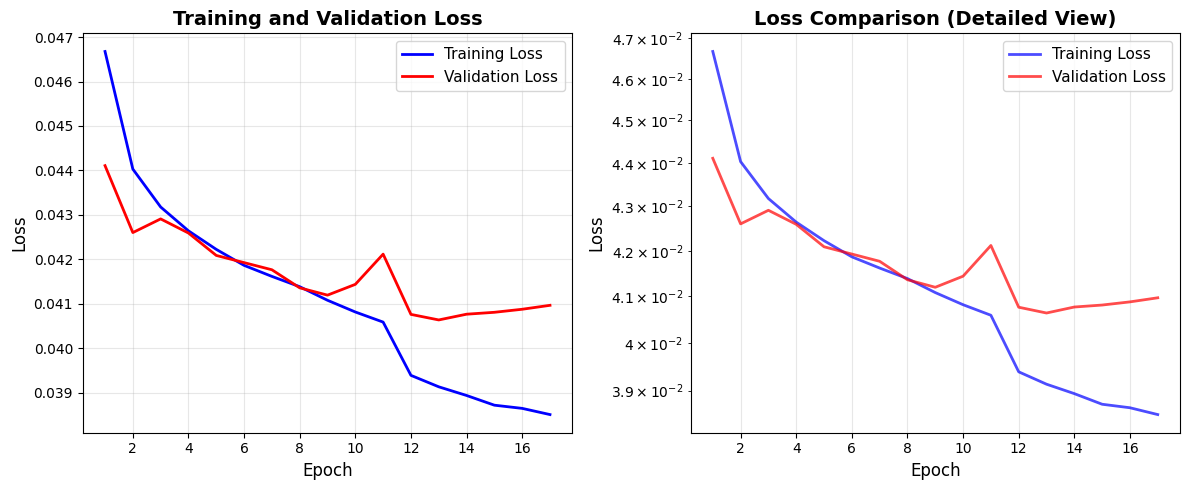


===== TRAINING SUMMARY =====
Final Training Loss: 0.0385
Final Validation Loss: 0.0410
Best Validation AUC: 0.8521
Total Epochs Trained: 17
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8187 | F1: 0.3993
[Test] Cardiomegaly AUC: 0.9406 | F1: 0.5000
[Test] Consolidation AUC: 0.7766 | F1: 0.2385
[Test] Edema AUC: 0.8806 | F1: 0.2165
[Test] Effusion AUC: 0.9014 | F1: 0.6089
[Test] Emphysema AUC: 0.9669 | F1: 0.5500
[Test] Fibrosis AUC: 0.8185 | F1: 0.1350
[Test] Hernia AUC: 0.9783 | F1: 0.6667
[Test] Infiltration AUC: 0.6983 | F1: 0.4086
[Test] Mass AUC: 0.9029 | F1: 0.4748
[Test] Nodule AUC: 0.7653 | F1: 0.3150
[Test] Pleural_Thickening AUC: 0.7932 | F1: 0.2282
[Test] Pneumonia AUC: 0.7243 | F1: 0.0609
[Test] Pneumothorax AUC: 0.8757 | F1: 0.3481
[Test] Avg AUC: 0.8458, Avg F1: 0.3679


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0422
Avg AUROC : 0.8458
Avg F1    : 0.3679

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8187     0.3993     0.3775    
Cardiomegaly         0.9406     0.5000     0.3737    
Consolidation        0.7766     0.2385     0.3360    
Edema                0.8806     0.2165     0.3266    
Effusion             0.9014     0.6089     0.4337    
Emphysema            0.9669     0.5500     0.3971    
Fibrosis             0.8185     0.1350     0.2578    
Hernia               0.9783     0.6667     0.6525    
Infiltration         0.6983     0.4086     0.3963    
Mass                 0.9029     0.4748     0.4231    
Nodule               0.7653     0.3150     0.3735    
Pleural_Thickening   0.7932     0.2282     0.2965    
Pneumonia            0.7243     0.0609     0.1870    
Pneumothorax         0.8757     0.3481     0.3606    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

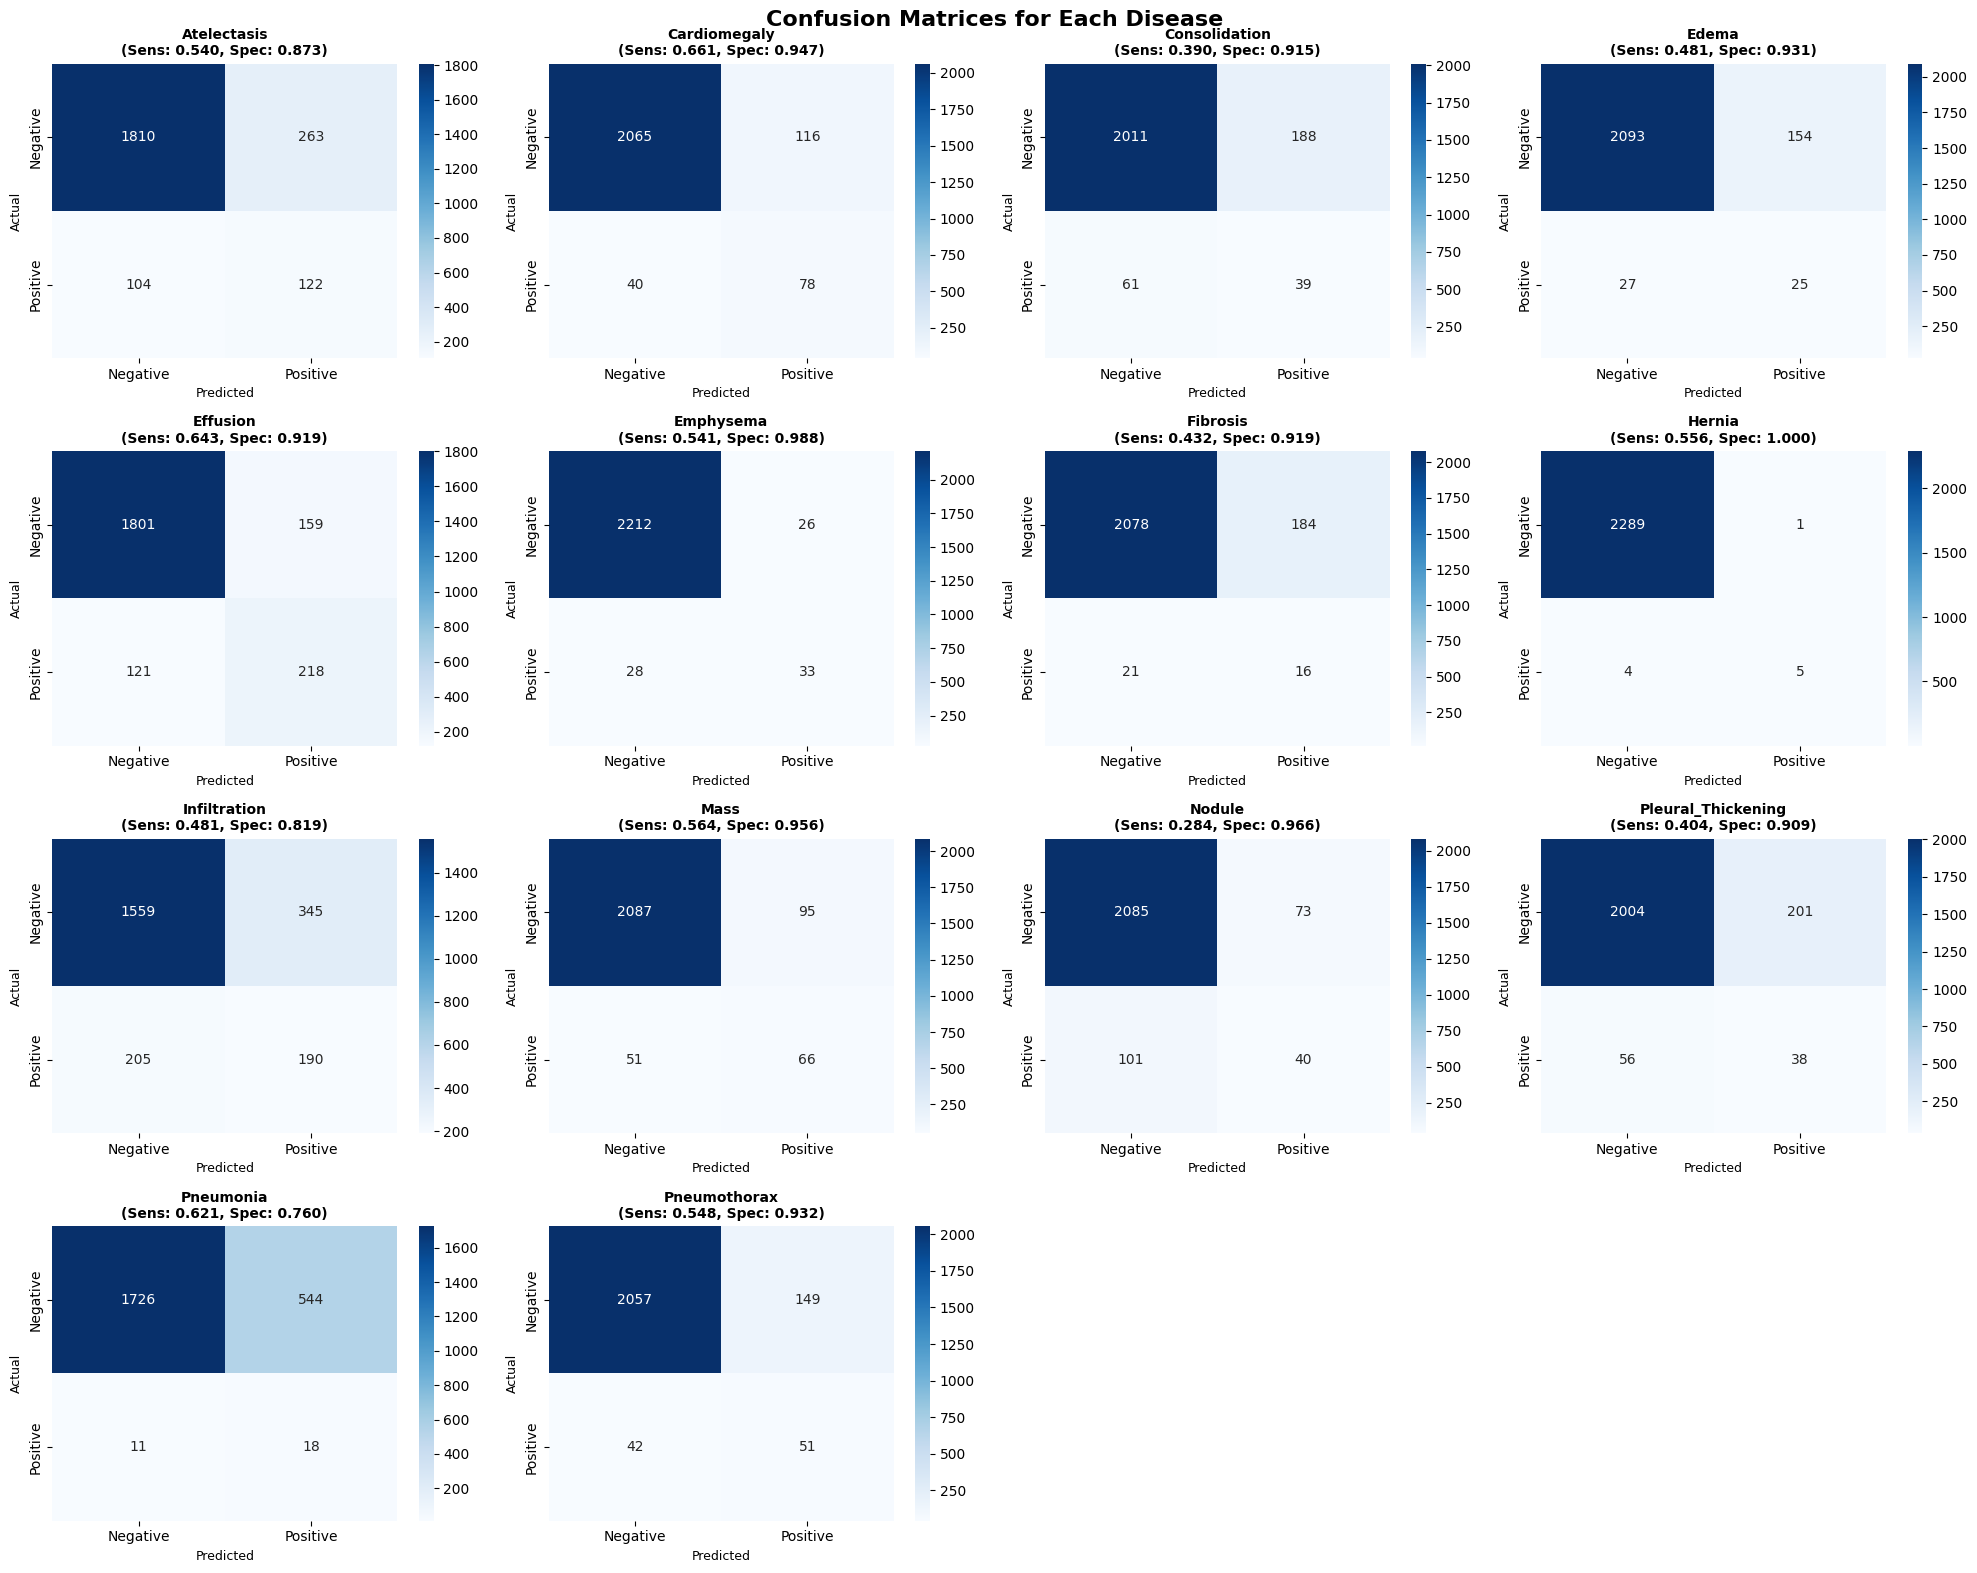

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          122    1810   263    104    0.540    0.873    0.317    0.946   
Cardiomegaly         78     2065   116    40     0.661    0.947    0.402    0.981   
Consolidation        39     2011   188    61     0.390    0.915    0.172    0.971   
Edema                25     2093   154    27     0.481    0.931    0.140    0.987   
Effusion             218    1801   159    121    0.643    0.919    0.578    0.937   
Emphysema            33     2212   26     28     0.541    0.988    0.559    0.988   
Fibrosis             16     2078   184    21     0.432    0.919    0.080    0.990   
Hernia               5      2289   1      4      0.556    1.000    0.833    0.998   
Infiltration         190    1559   345    205    0.481    0.819    0.355    0.884   
Ma